In [150]:
import pysbm
import networkx as nx
import matplotlib.pylab as plt
import pandas as pd
import numpy as np


In [151]:
post_df = pd.read_pickle("C:\\Users\\EbiharaYuito\\sotsuken\\pysbm\\pysbm\\Network Data\\sorted_id_count_fiscal_2013_enriched_top100.pkl")
post_df_2 = pd.read_pickle("C:\\Users\\EbiharaYuito\\sotsuken\\pysbm\\pysbm\\Network Data\\sorted_id_count_fiscal_2013_enriched_top101to200.pkl")
print(post_df.tail())
print(post_df_2.head())
post_df = pd.concat([post_df, post_df_2])

    item_id  count  category_id1  category_id2  price  \
95  2085936    844            15         15001   1260   
96  2140210    842            10         10001  13650   
97  2236828    838            10         10001  51450   
98  1980753    830            12         12001   6300   
99  1384638    829            11         11002   4900   

                                                posts  
95  [{'user': 371744, 'date': 2013-09-27 00:00:00}...  
96  [{'user': 385606, 'date': 2013-10-06 00:00:00}...  
97  [{'user': 379678, 'date': 2013-10-18 00:00:00}...  
98  [{'user': 346055, 'date': 2013-09-11 00:00:00}...  
99  [{'user': 150045, 'date': 2013-04-02 00:00:00}...  
     item_id  count  category_id1  category_id2  price  \
100  2089232    827            10         10005   9720   
101  1979614    827            12         12001   3564   
102  2093291    822            13         13002   7245   
103  2089138    819            10         10002   8208   
104  1928661    814            

In [152]:
#item_idとpostsに含まれるuserの値を使って有向2部グラフを作成する
#2013年12月31日までのデータを使用する

import networkx as nx
import datetime
# Create an empty directed graph
graph = nx.DiGraph()

# Iterate through the DataFrame rows
for index, row in post_df.iterrows():
    item_id = row['item_id']
    item_node_name = "item_" + str(item_id)
    posts = row['posts']
    
    # Add item_id as a node (assuming it's a valid identifier)
    graph.add_node(item_node_name, bipartite=0)  # bipartite=0 for items
    
    posted_users = []
    for post in posts:
      if post["date"] <= datetime.datetime(2013, 12, 31):
        posted_users.append(post["user"])
        
    for user in posted_users:
        user_node_name = "user_" + str(user)
        graph.add_node(user_node_name, bipartite=1)  # bipartite=1 for users
        if not graph.has_edge(user_node_name, item_node_name):  # エッジが存在しない場合のみ追加
            graph.add_edge(user_node_name, item_node_name) # user points to item
                
# Now the 'graph' object contains your bipartite graph

In [153]:
# ユーザーごとの投稿数を計算
user_post_counts = {}
for node in graph.nodes():
    if node.startswith('user_'):
        user_post_counts[node] = graph.out_degree(node)

# 投稿数の多い上位200ユーザーを取得
top_users = sorted(user_post_counts.items(), key=lambda x: x[1], reverse=True)[:800]
top_user_nodes = [user[0] for user in top_users]

# 新しいグラフを作成
filtered_graph = graph.copy()

# 上位200ユーザー以外のユーザーノードを削除
users_to_remove = [node for node in graph.nodes() if node.startswith('user_') and node not in top_user_nodes]
filtered_graph.remove_nodes_from(users_to_remove)

# 孤立したアイテムノードを削除
isolated_nodes = list(nx.isolates(filtered_graph))
filtered_graph.remove_nodes_from(isolated_nodes)

# 元のグラフを更新
graph = filtered_graph


In [154]:
# prompt: グラフの情報を確認する

print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())
print("Density of the graph:", nx.density(graph))
# check if the graph is directed or undirected
print("Is directed:", nx.is_directed(graph))

# # Check for strongly connected components
# scc = list(nx.strongly_connected_components(graph))
# print("Strongly connected components:", scc)

# # Check for weakly connected components
# wcc = list(nx.weakly_connected_components(graph))
# print("Weakly connected components:", wcc)

# Calculate degree centrality for items
item_degree_centrality = nx.degree_centrality(graph)
print("Item degree centrality:", sorted(item_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10])

# Calculate degree centrality for users
user_degree_centrality = nx.degree_centrality(graph)
print("User degree centrality:", sorted(user_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10])

Number of nodes: 998
Number of edges: 27852
Density of the graph: 0.02799179100427535
Is directed: True
Item degree centrality: [('item_2232034', 0.3650952858575727), ('item_2188911', 0.34704112337011034), ('item_2266395', 0.3329989969909729), ('item_1980446', 0.32698094282848544), ('item_1084549', 0.31093279839518556), ('item_1084556', 0.31093279839518556), ('item_1084552', 0.31093279839518556), ('item_1084550', 0.30992978936810434), ('item_1084551', 0.30992978936810434), ('item_2136071', 0.30992978936810434)]
User degree centrality: [('item_2232034', 0.3650952858575727), ('item_2188911', 0.34704112337011034), ('item_2266395', 0.3329989969909729), ('item_1980446', 0.32698094282848544), ('item_1084549', 0.31093279839518556), ('item_1084556', 0.31093279839518556), ('item_1084552', 0.31093279839518556), ('item_1084550', 0.30992978936810434), ('item_1084551', 0.30992978936810434), ('item_2136071', 0.30992978936810434)]


In [155]:
num_blocks = 30

In [156]:
standard_partition = pysbm.NxPartition(
    graph=graph, 
    number_of_blocks=num_blocks)
# degree_corrected_partition = pysbm.NxPartition(
#     graph=graph, 
#     number_of_blocks=5,
#     representation=standard_partition.get_representation())
standard_objective_function = pysbm.TraditionalUnnormalizedLogLikelyhood(is_directed=True)
# degree_corrected_objective_function = pysbm.DegreeCorrectedUnnormalizedLogLikelyhood(is_directed=False)

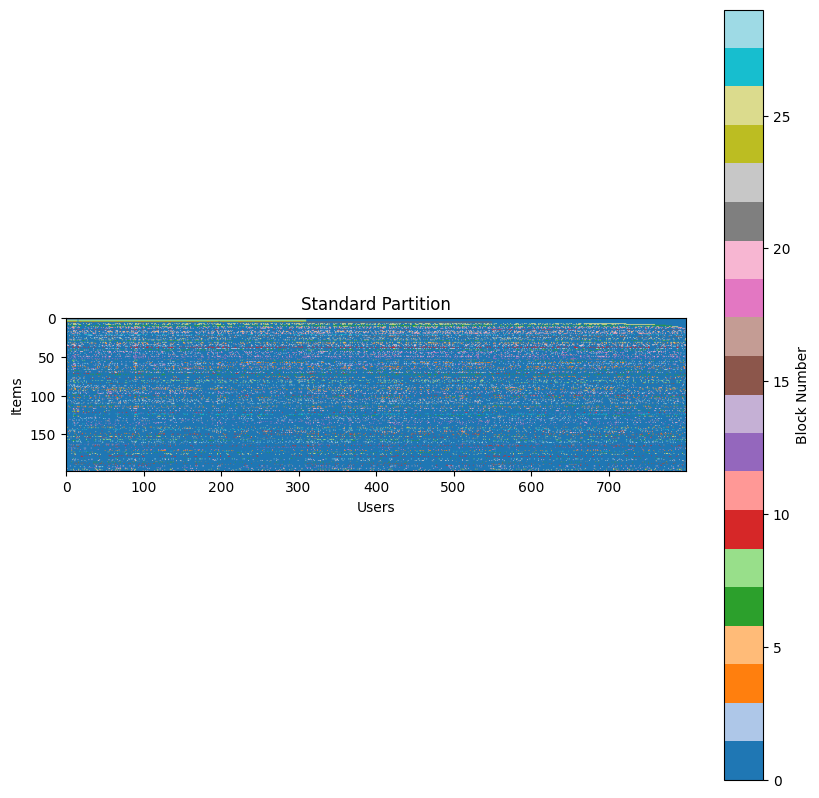

In [157]:
# グラフを隣接行列に変換
items = [n for n in graph.nodes() if graph.nodes[n]['bipartite'] == 0]
users = [n for n in graph.nodes() if graph.nodes[n]['bipartite'] == 1]
adj_matrix = np.zeros((len(items), len(users)))

# 行列を作成
for i, item in enumerate(items):
    for j, user in enumerate(users):
        if graph.has_edge(item, user) or graph.has_edge(user, item):
            adj_matrix[i,j] = standard_partition.get_block_of_node(item)

# 行列をプロット
plt.figure(figsize=(10,10))
plt.imshow(adj_matrix, cmap='tab20')
plt.title('Standard Partition')
plt.xlabel('Users')
plt.ylabel('Items')
plt.colorbar(label='Block Number')
plt.show()

# # 同様に degree corrected partition も表示
# plt.figure(figsize=(10,10))
# plt.imshow(adj_matrix, cmap='binary')
# plt.title('Degree Corrected Partition')
# plt.xlabel('Users')
# plt.ylabel('Items')
# plt.show()

In [158]:
standard_inference = pysbm.MetropolisHastingInference(graph, standard_objective_function, standard_partition)
# degree_corrected_inference = pysbm.MetropolisHastingInference(graph, degree_corrected_objective_function, degree_corrected_partition)

In [159]:
from tqdm import tqdm  # 進行バーの表示用

best_partition = None
best_value = float('-inf')

partition = pysbm.NxPartition(
    graph=graph, 
    number_of_blocks=num_blocks
)
    
inference = pysbm.MetropolisHastingInference(
    graph=graph,
    objective_function=standard_objective_function,
    partition=partition
)

for step in range(200000):
    inference.infer_stepwise()
    if step % 100 == 0:  # 100ステップごとに評価
        current_value = standard_objective_function.calculate(partition)
        if current_value > best_value:
            best_value = current_value
            best_partition = partition.get_representation()
            print(f"Step {step}: New best value {best_value}")

Step 0: New best value -97151.2402610007
Step 100: New best value -95872.73502663981
Step 200: New best value -94881.13217363274
Step 300: New best value -93604.3946212239
Step 400: New best value -92317.02353292829
Step 500: New best value -90783.23162583893
Step 600: New best value -89445.97090194823
Step 700: New best value -87677.21648223362
Step 800: New best value -86484.5248908334
Step 900: New best value -84771.76889999333
Step 1000: New best value -83272.91191683609
Step 1100: New best value -81266.98393765646
Step 1200: New best value -79937.03574745795
Step 1300: New best value -78190.69912833857
Step 1400: New best value -75616.74794217563
Step 1500: New best value -74133.46799372422
Step 1600: New best value -72535.03067004944
Step 1700: New best value -70382.86789901093
Step 1800: New best value -69633.33635651697
Step 1900: New best value -67867.003707508
Step 2000: New best value -66357.03604420096
Step 2100: New best value -64841.77168408118
Step 2200: New best value -

In [160]:
# standard_inference.infer_stochastic_block_model()
# degree_corrected_inference.infer_stochastic_block_model()

[0, 0, 0, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

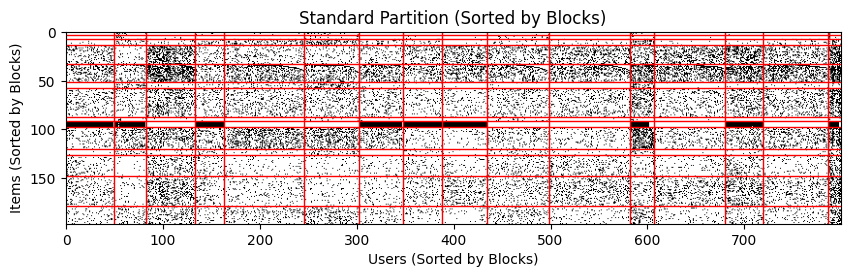

In [161]:
# ノードをブロックごとにソート
items_sorted = sorted(items, key=lambda x: partition.get_block_of_node(x))
users_sorted = sorted(users, key=lambda x: partition.get_block_of_node(x))

# ブロックの境界を見つける
item_blocks = [partition.get_block_of_node(item) for item in items_sorted]
print(item_blocks)
user_blocks = [partition.get_block_of_node(user) for user in users_sorted]
print(user_blocks)
item_boundaries = [i for i in range(1, len(item_blocks)) if item_blocks[i] != item_blocks[i-1]]
user_boundaries = [i for i in range(1, len(user_blocks)) if user_blocks[i] != user_blocks[i-1]]

# 並び替えた行列を作成
adj_matrix_sorted = np.zeros((len(items), len(users)))
for i, item in enumerate(items_sorted):
    for j, user in enumerate(users_sorted):
        if graph.has_edge(item, user) or graph.has_edge(user, item):
            adj_matrix_sorted[i,j] = 1

# 並び替えた行列をプロット
plt.figure(figsize=(10,10))
plt.imshow(adj_matrix_sorted, cmap='binary')

# ブロックの境界に線を追加
for boundary in item_boundaries:
    plt.axhline(y=boundary-0.5, color='r', linestyle='-', linewidth=1)
for boundary in user_boundaries:
    plt.axvline(x=boundary-0.5, color='r', linestyle='-', linewidth=1)

plt.title('Standard Partition (Sorted by Blocks)')
plt.xlabel('Users (Sorted by Blocks)')
plt.ylabel('Items (Sorted by Blocks)')
plt.show()


[0, 0, 0, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

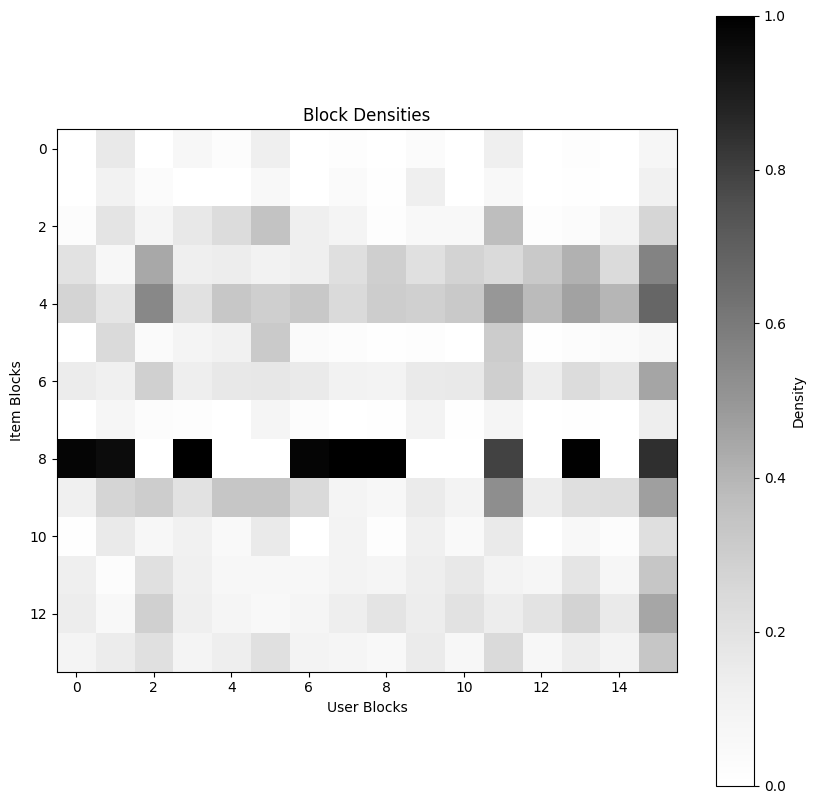

In [162]:
# ノードをブロックごとにソート
items_sorted = sorted(items, key=lambda x: partition.get_block_of_node(x))
users_sorted = sorted(users, key=lambda x: partition.get_block_of_node(x))

# ブロックの境界を見つける
item_blocks = [partition.get_block_of_node(item) for item in items_sorted]
print(item_blocks)
user_blocks = [partition.get_block_of_node(user) for user in users_sorted]
print(user_blocks)
item_boundaries = [i for i in range(1, len(item_blocks)) if item_blocks[i] != item_blocks[i-1]]
user_boundaries = [i for i in range(1, len(user_blocks)) if user_blocks[i] != user_blocks[i-1]]

# ブロックサイズを計算
item_block_sizes = []
user_block_sizes = []
prev_boundary = 0
for boundary in item_boundaries:
    item_block_sizes.append(boundary - prev_boundary)
    prev_boundary = boundary
item_block_sizes.append(len(items) - prev_boundary)

prev_boundary = 0
for boundary in user_boundaries:
    user_block_sizes.append(boundary - prev_boundary)
    prev_boundary = boundary
user_block_sizes.append(len(users) - prev_boundary)

# ブロックごとの密度を計算
num_item_blocks = len(item_block_sizes)
num_user_blocks = len(user_block_sizes)
block_densities = np.zeros((num_item_blocks, num_user_blocks))

start_i = 0
for i in range(num_item_blocks):
    size_i = item_block_sizes[i]
    start_j = 0
    for j in range(num_user_blocks):
        size_j = user_block_sizes[j]
        block = adj_matrix_sorted[start_i:start_i+size_i, start_j:start_j+size_j]
        density = np.sum(block) / (size_i * size_j)
        block_densities[i,j] = density
        start_j += size_j
    start_i += size_i

# ブロック密度をプロット
plt.figure(figsize=(10,10))
plt.imshow(block_densities, cmap='Greys')

plt.title('Block Densities')
plt.xlabel('User Blocks')
plt.ylabel('Item Blocks')
plt.colorbar(label='Density')
plt.show()


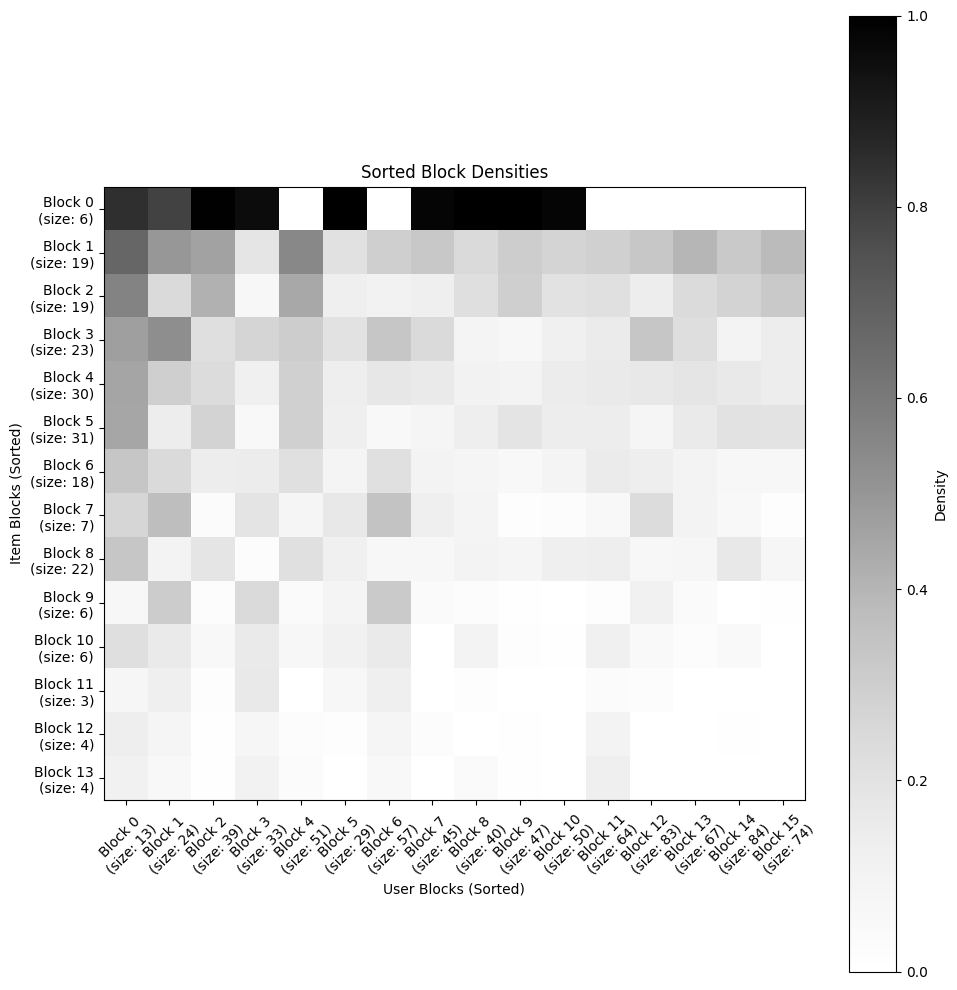

In [163]:
# ブロックの密度に基づいて並び替え

# 各行の平均密度を計算
row_means = np.mean(block_densities, axis=1)
# 行を密度の降順でソート
row_order = np.argsort(-row_means)
block_densities = block_densities[row_order]
item_block_sizes = [item_block_sizes[i] for i in row_order]

# 各列の平均密度を計算 
col_means = np.mean(block_densities, axis=0)
# 列を密度の降順でソート
col_order = np.argsort(-col_means)
block_densities = block_densities[:, col_order]
user_block_sizes = [user_block_sizes[i] for i in col_order]

# 並び替えた結果を再プロット
plt.figure(figsize=(10,10))
plt.imshow(block_densities, cmap='Greys')
plt.title('Sorted Block Densities')

# ブロックサイズを軸ラベルに追加
user_labels = [f'Block {i}\n(size: {size})' for i, size in enumerate(user_block_sizes)]
item_labels = [f'Block {i}\n(size: {size})' for i, size in enumerate(item_block_sizes)]

plt.xticks(range(len(user_block_sizes)), user_labels, rotation=45)
plt.yticks(range(len(item_block_sizes)), item_labels)

plt.xlabel('User Blocks (Sorted)')
plt.ylabel('Item Blocks (Sorted)')
plt.colorbar(label='Density')
plt.tight_layout()
plt.show()


In [164]:
print(item_boundaries)

[3, 7, 14, 33, 52, 58, 88, 92, 98, 121, 127, 149, 180]


In [165]:
# 各ブロックのユーザ数を計算して表示
modified_user_boundaries = [0] + user_boundaries
print("各ブロックのユーザ数:")
for block_idx, original_block_idx in enumerate(col_order):
    start = modified_user_boundaries[original_block_idx] 
    end = modified_user_boundaries[original_block_idx + 1] if original_block_idx + 1 < len(modified_user_boundaries) else len(users_sorted)
    user_count = end - start
    print(f"ブロック {block_idx} (元のブロック {original_block_idx}): {user_count} ユーザ")


各ブロックのユーザ数:
ブロック 0 (元のブロック 15): 13 ユーザ
ブロック 1 (元のブロック 11): 24 ユーザ
ブロック 2 (元のブロック 13): 39 ユーザ
ブロック 3 (元のブロック 1): 33 ユーザ
ブロック 4 (元のブロック 2): 51 ユーザ
ブロック 5 (元のブロック 3): 29 ユーザ
ブロック 6 (元のブロック 5): 57 ユーザ
ブロック 7 (元のブロック 6): 45 ユーザ
ブロック 8 (元のブロック 7): 40 ユーザ
ブロック 9 (元のブロック 8): 47 ユーザ
ブロック 10 (元のブロック 0): 50 ユーザ
ブロック 11 (元のブロック 9): 64 ユーザ
ブロック 12 (元のブロック 4): 83 ユーザ
ブロック 13 (元のブロック 14): 67 ユーザ
ブロック 14 (元のブロック 10): 84 ユーザ
ブロック 15 (元のブロック 12): 74 ユーザ


In [169]:
# 並び替え後のブロック順序(row_order)に基づいて、各ブロックのアイテムIDを表示
block_avg_prices = []
modified_item_boundaries = [0] + item_boundaries
for block_idx, original_block_idx in enumerate(row_order):
    start = modified_item_boundaries[original_block_idx]
    end = modified_item_boundaries[original_block_idx + 1] if original_block_idx + 1 < len(modified_item_boundaries) else len(items_sorted)
    block_items = items_sorted[start:end]
    block_ids = [items.replace("item_", "") for items in block_items]
    avg_price = np.mean(post_df[post_df['item_id'].isin(block_ids)]['price'])
    block_avg_prices.append(avg_price)
    print(f"\nブロック {block_idx} (元のブロック {original_block_idx}) のアイテムID:")
    print(block_ids)
    print(f"ブロック {block_idx} の平均価格: {avg_price}")

# 各ブロックのcategory1の値の割合を計算して表示
print("\n各ブロックのcategory1の割合:")
modified_item_boundaries = [0] + item_boundaries
for block_idx, original_block_idx in enumerate(row_order):
    start = modified_item_boundaries[original_block_idx]
    end = modified_item_boundaries[original_block_idx + 1] if original_block_idx + 1 < len(modified_item_boundaries) else len(items_sorted)
    block_items = items_sorted[start:end]
    block_ids = [items.replace("item_", "") for items in block_items]
    
    # ブロック内のアイテムのcategory1の値を取得
    block_categories = post_df[post_df['item_id'].isin(block_ids)]['category_id1'].value_counts()
    total_items = len(block_ids)
    
    print(f"\nブロック {block_idx} (元のブロック {original_block_idx}):")
    for category, count in block_categories.items():
        percentage = (count / total_items) * 100
        print(f"カテゴリー {category}: {percentage:.2f}%")




ブロック 0 (元のブロック 8) のアイテムID:
['1084549', '1084556', '1084550', '1084552', '1084551', '1084553']
ブロック 0 の平均価格: 3360.0

ブロック 1 (元のブロック 4) のアイテムID:
['2232034', '2014374', '2188911', '2266395', '2136071', '1980446', '2244348', '2114743', '2131996', '2089405', '2232487', '2212785', '2274824', '2281160', '2188914', '2181973', '2198275', '2249831', '2212774']
ブロック 1 の平均価格: 12597.368421052632

ブロック 2 (元のブロック 3) のアイテムID:
['2109119', '1928020', '2233094', '2127509', '1980808', '1980437', '2299783', '2145271', '2132531', '2115076', '2299208', '1979822', '2134968', '2232030', '2176994', '2222968', '1980391', '2178776', '2132438']
ブロック 2 の平均価格: 9647.473684210527

ブロック 3 (元のブロック 9) のアイテムID:
['2014372', '1880573', '2288705', '2014368', '2148826', '2305707', '2232505', '2282438', '2014370', '2221782', '2301121', '2132790', '1929342', '1982452', '2227910', '2232470', '2275002', '2299524', '2311683', '2299492', '2114687', '2245189', '2284049']
ブロック 3 の平均価格: 18036.91304347826

ブロック 4 (元のブロック 6) のアイテムID:
[

C:\Users\EbiharaYuito\AppData\Local\Temp\ipykernel_21444\1272954520.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(block_prices,


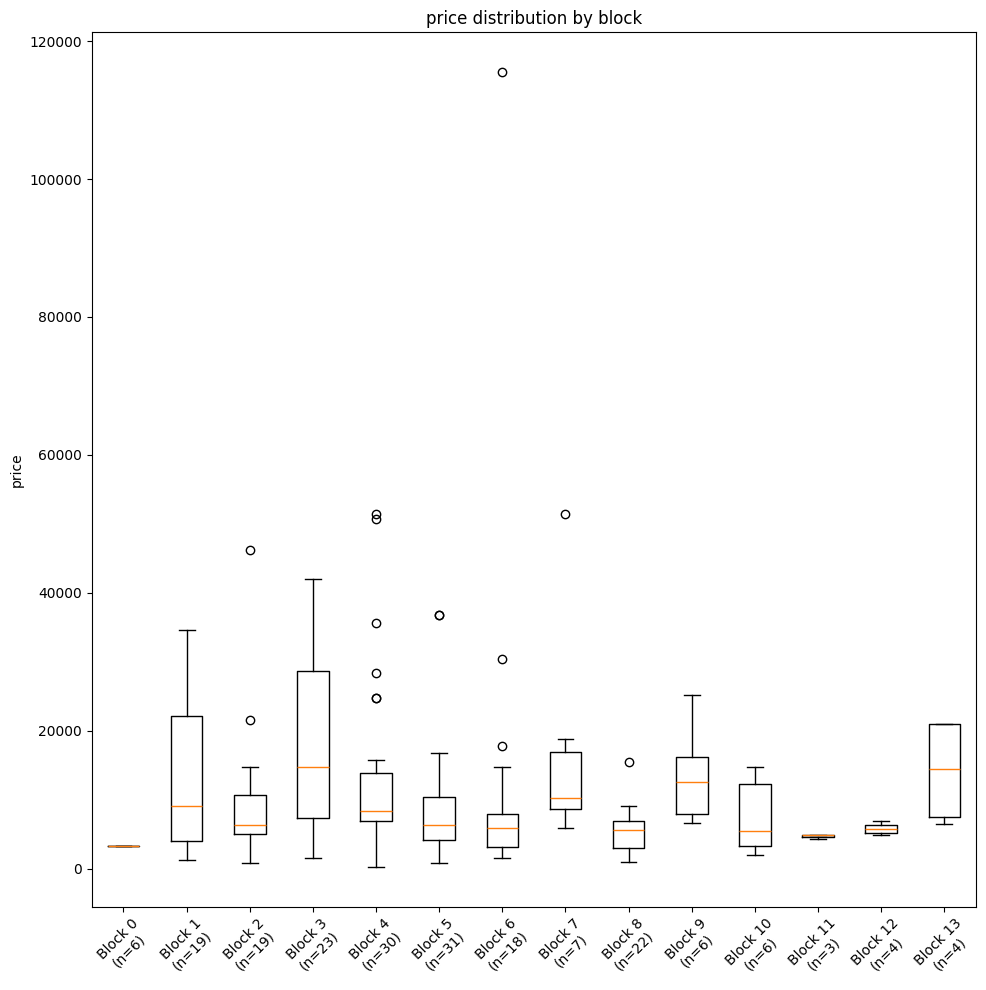

In [177]:
# ブロックごとの価格分布を箱ひげ図で表示
plt.figure(figsize=(10,10))

# 各ブロックの価格データを収集
block_prices = []
block_labels = []

modified_item_boundaries = [0] + item_boundaries
for block_idx, original_block_idx in enumerate(row_order):
    start = modified_item_boundaries[original_block_idx]
    end = modified_item_boundaries[original_block_idx + 1] if original_block_idx + 1 < len(modified_item_boundaries) else len(items_sorted)
    block_items = items_sorted[start:end]
    block_ids = [items.replace("item_", "") for items in block_items]
    
    # ブロック内のアイテムの価格を取得
    block_prices.append(post_df[post_df['item_id'].isin(block_ids)]['price'].values)
    # block_labels.append(f'Block {block_idx}\n(original:{original_block_idx})\n(n={len(block_ids)})')
    block_labels.append(f'Block {block_idx}\n(n={len(block_ids)})')

# 箱ひげ図を描画
plt.boxplot(block_prices,
            labels=block_labels,
            # showfliers=False
            )
plt.title('price distribution by block')
plt.ylabel('price')
plt.xticks(rotation=45)

# y軸を対数スケールに設定（価格の範囲が広いため）
# plt.yscale('log')

plt.tight_layout()
plt.show()


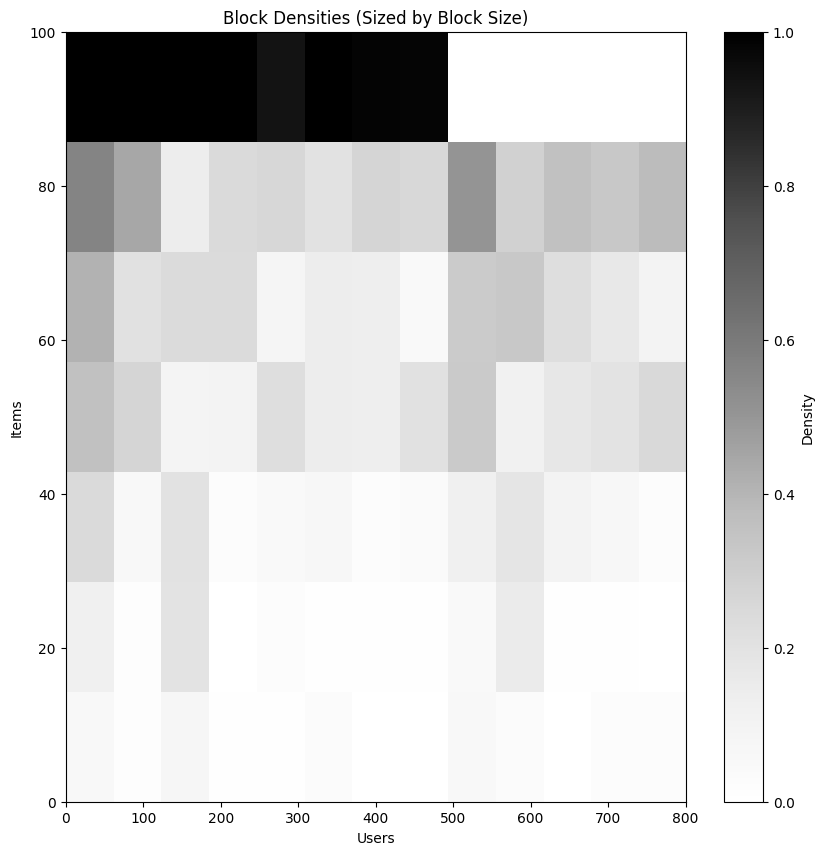

In [112]:
# ブロックサイズに基づいてヒートマップを描画
plt.figure(figsize=(10,10))

# ブロックサイズの計算
modified_user_boundaries = [0] + user_boundaries
modified_item_boundaries = [0] + item_boundaries

# ユーザブロックのサイズを計算
user_block_sizes = []
for original_block_idx in col_order:
    start = modified_user_boundaries[original_block_idx]
    end = modified_user_boundaries[original_block_idx + 1] if original_block_idx + 1 < len(modified_user_boundaries) else len(users_sorted)
    user_block_sizes.append(end - start)

# アイテムブロックのサイズを計算 
item_block_sizes = []
for original_block_idx in row_order:
    start = modified_item_boundaries[original_block_idx]
    end = modified_item_boundaries[original_block_idx + 1] if original_block_idx + 1 < len(modified_item_boundaries) else len(items_sorted)
    item_block_sizes.append(end - start)

# サイズに応じたヒートマップを描画
plt.imshow(block_densities, 
           aspect='auto',
           extent=[0, sum(user_block_sizes), 0, sum(item_block_sizes)],
           cmap='Greys')

# # ブロック境界線を描画
# user_cumsum = np.cumsum(user_block_sizes)
# item_cumsum = np.cumsum(item_block_sizes)

# for x in user_cumsum[:-1]:
#     plt.axvline(x=x, color='red', linestyle='-', alpha=0.3)
# for y in item_cumsum[:-1]:
#     plt.axhline(y=y, color='red', linestyle='-', alpha=0.3)

plt.title('Block Densities (Sized by Block Size)')
plt.xlabel('Users')
plt.ylabel('Items')
plt.colorbar(label='Density')
plt.show()


In [113]:
# position = nx.spring_layout(graph)
# print("Standard SBM with the splitting into high and low degree nodes")
# nx.draw(graph, position, node_color=['r' if standard_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
# plt.show()
# print("Degree Corrected SBM")
# nx.draw(graph, position, node_color=['r' if degree_corrected_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
# plt.show()